In [1]:
from operator import index

import pandas as pd
import numpy as np
from datetime import datetime

from IPython.core.pylabtools import figsize
from pytz import timezone
import pytz
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 1

## a

In [2]:
mom_dict = {
    "nuclear": {"cap": 10, "vc": 10},
    "lignite": {"cap": 20, "vc": 30},
    "coal": {"cap": 15, "vc": 40},
    "gas": {"cap": 5, "vc": 80},
    "ror": {"cap": 20, "vc": 0},
    "wind": {"cap": 30, "vc": 0},
}
mom_df = pd.DataFrame.from_dict(mom_dict, orient="index")

In [3]:
mom_df

,cap,vc
nuclear,10,10
lignite,20,30
coal,15,40
gas,5,80
ror,20,0
wind,30,0


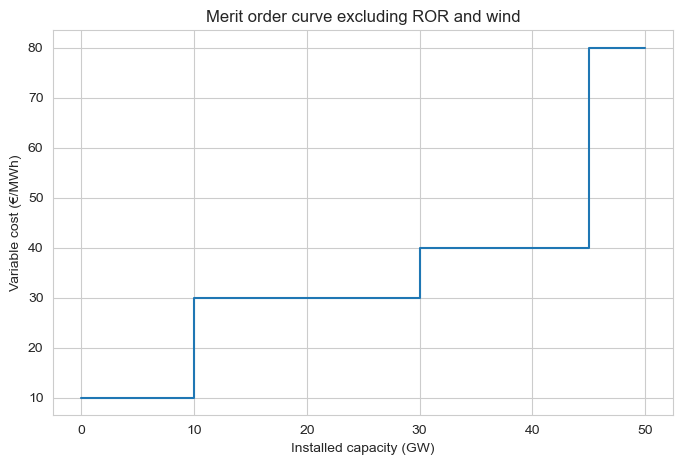

In [4]:
plot_df = mom_df[~mom_df.index.isin(["ror", "wind"])].copy()
plot_df["cum_cap"] = plot_df["cap"].cumsum()

plt.figure(figsize=(8, 5))
plt.step([0] + plot_df["cum_cap"].values.tolist(), [10] + plot_df["vc"].values.tolist(), where="pre")
plt.title("Merit order curve excluding ROR and wind")
plt.xlabel("Installed capacity (GW)")
plt.ylabel("Variable cost (€/MWh)")
plt.show()

## b

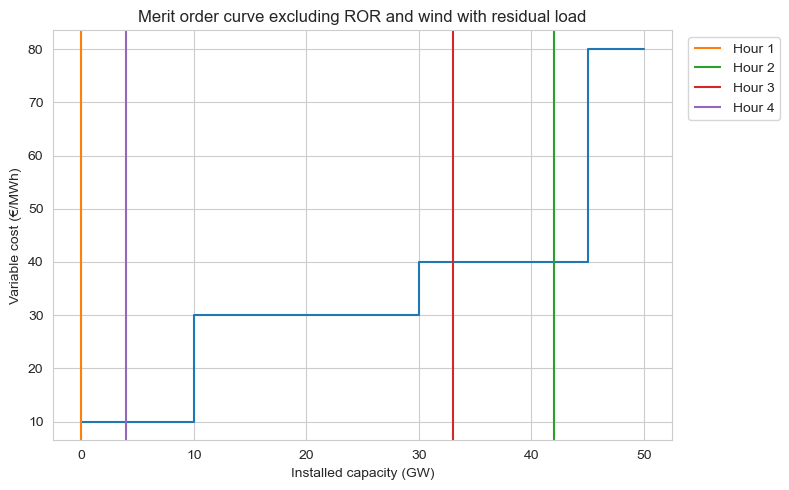

In [5]:
rdl_1 = 10 - (mom_df.loc["ror", "cap"] * 0.5)
rdl_2 = 50 - (mom_df.loc["ror", "cap"] * 0.4)
rdl_3 = 50 - (mom_df.loc["ror", "cap"] * 0.4 + mom_df.loc["wind", "cap"] * 0.3)
rdl_4 = 20 - (mom_df.loc["ror", "cap"] * 0.2 + mom_df.loc["wind", "cap"] * 0.4)

plt.figure(figsize=(8, 5))
plt.step([0] + plot_df["cum_cap"].values.tolist(), [10] + plot_df["vc"].values.tolist(), where="pre")

ylim = plt.gca().get_ylim()
plt.vlines(rdl_1, 0, ylim[1], color="#ff7f0e", label="Hour 1")
plt.vlines(rdl_2, 0, ylim[1], color="#2ca02c", label="Hour 2")
plt.vlines(rdl_3, 0, ylim[1], color="#d62728", label="Hour 3")
plt.vlines(rdl_4, 0, ylim[1], color="#9467bd", label="Hour 4")

plt.title("Merit order curve excluding ROR and wind with residual load")
plt.xlabel("Installed capacity (GW)")
plt.ylabel("Variable cost (€/MWh)")
plt.ylim(ylim)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper center")
plt.tight_layout()
plt.show()

In [6]:
rdl_4

4.0

In [7]:
480000/21000

22.857142857142858

# 2

## a

In [8]:
data = pl.read_csv("data/FR_timeseries.csv", separator=";", decimal_comma=True, row_index_offset=0, infer_schema=False)

In [9]:
data = data.with_columns(
    pl.col("load_actual").str.replace(",", ".").cast(pl.Float64),
    pl.col("load_forecast").str.replace(",", ".").cast(pl.Float64),
    pl.col("solar_actual").str.replace(",", ".").cast(pl.Float64),
    pl.col("wind_actual").str.replace(",", ".").cast(pl.Float64),
    pl.col("cet_cest_timestamp").str.to_datetime(format="%d.%m.%Y %H:%M"),
).drop("utc_timestamp").rename({"cet_cest_timestamp": "datetime"})

In [10]:
year = 2019
data = data.filter(
    pl.col("datetime").dt.year() == year
)

In [11]:
data = data.to_pandas()

In [12]:
data["residual_load"] = data["load_actual"] - (data["solar_actual"] + data["wind_actual"])

# convert to GW
data["load_actual"] /= 1000
data["residual_load"] /= 1000

load_sorted = data[["load_actual"]].sort_values(by=["load_actual"], ascending=False)
load_sorted.reset_index(drop=True, inplace=True)
load_sorted["hour_index"] = load_sorted.index + 1

rdl_sorted = data[["residual_load"]].sort_values(by=["residual_load"], ascending=False)
rdl_sorted.reset_index(drop=True, inplace=True)
rdl_sorted["hour_index"] = load_sorted.index + 1

plot_df = load_sorted.merge(rdl_sorted, on="hour_index", how="left", validate="one_to_one")

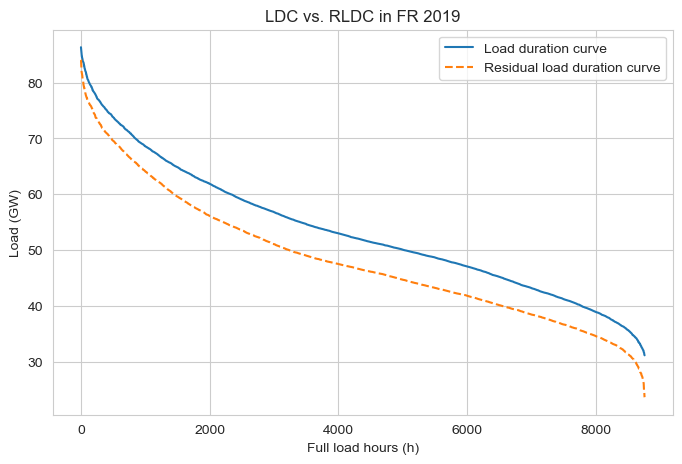

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(plot_df["hour_index"], plot_df["load_actual"], label="Load duration curve")
plt.plot(plot_df["hour_index"], plot_df["residual_load"], label="Residual load duration curve", linestyle="dashed")
plt.xlabel("Full load hours (h)")
plt.ylabel("Load (GW)")
plt.title("LDC vs. RLDC in FR 2019")
plt.legend()
plt.show()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       8760 non-null   datetime64[us]
 1   load_actual    8755 non-null   float64       
 2   load_forecast  8760 non-null   float64       
 3   solar_actual   8755 non-null   float64       
 4   wind_actual    8755 non-null   float64       
 5   residual_load  8755 non-null   float64       
dtypes: datetime64[us](1), float64(5)
memory usage: 410.8 KB


In [15]:
8760-8755

5

## b

In [16]:
scm_dict = {"nuclear": {"afc": 262, "vc": 35},
            "coal": {"afc": 117, "vc": 135},
            "gas": {"afc": 58, "vc": 115}, }

In [17]:
cost_df = pd.DataFrame({"hour": np.arange(1, 8761)})

In [18]:
for tech, costs in scm_dict.items():
    cost_df[tech] = cost_df["hour"] * costs["vc"] / 1000 + costs["afc"]

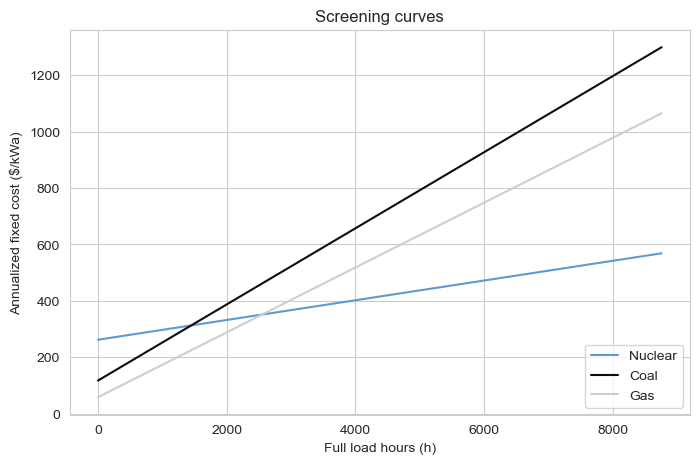

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(cost_df["hour"], cost_df["nuclear"], label="Nuclear", c="#5d9ad1")
plt.plot(cost_df["hour"], cost_df["coal"], label="Coal", c="#0d0b0f")
plt.plot(cost_df["hour"], cost_df["gas"], label="Gas", c="#d1ceca")
plt.title("Screening curves")
plt.xlabel("Full load hours (h)")
plt.ylabel("Annualized fixed cost ($/kWa)")
plt.legend(loc="lower right")
plt.show()

In [20]:
import sympy as sym
# Nuke-Coal
x, y = sym.symbols("x,y")
eq1 = sym.Eq(0.035*x - y, -262)
eq2 = sym.Eq(0.135*x - y, -117)
res = sym.solve([eq1, eq2], (x, y))
print(res)

{x: 1450.00000000000, y: 312.750000000000}


In [21]:
# Coal - Gas
x, y = sym.symbols("x,y")
eq1 = sym.Eq(0.135*x - y, -117)
eq2 = sym.Eq(0.115*x - y, -58)
res = sym.solve([eq1, eq2], (x, y))
print(res)

{x: -2950.00000000000, y: -281.250000000000}


In [22]:
# Nuke - Gas
x, y = sym.symbols("x,y")
eq1 = sym.Eq(0.035*x - y, -262)
eq2 = sym.Eq(0.115*x - y, -58)
res = sym.solve([eq1, eq2], (x, y))
print(res)

{x: 2550.00000000000, y: 351.250000000000}


## c

In [23]:
cap_mix = pd.DataFrame({"nuclear": 53,
                        "gas": 31,},
                       index=["cap"])

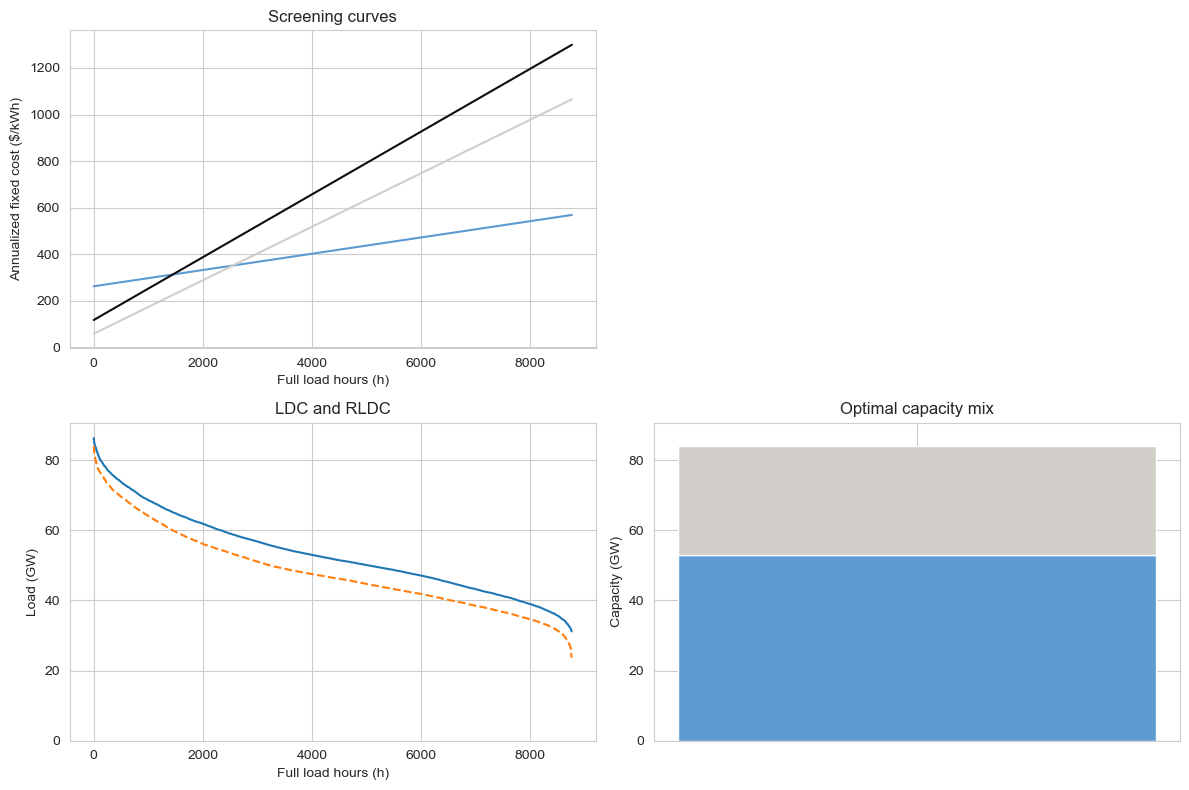

In [24]:
from matplotlib.patches import ConnectionPatch

# Nuke-coal intersection
cap_mix = pd.DataFrame({"nuclear": 53,
                        "gas": 31,},
                       index=["cap"])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(cost_df["hour"], cost_df["nuclear"], label="Nuclear", c="#5d9ad1")
axs[0, 0].plot(cost_df["hour"], cost_df["coal"], label="Coal", c="#0d0b0f")
axs[0, 0].plot(cost_df["hour"], cost_df["gas"], label="Gas", c="#d1ceca")
axs[0, 0].set_title("Screening curves")
axs[0, 0].set_xlabel("Full load hours (h)")
axs[0, 0].set_ylabel("Annualized fixed cost ($/kWh)")

axs[1, 0].sharex(axs[0, 0])
axs[1, 0].plot(plot_df["hour_index"], plot_df["load_actual"], label="Load duration curve")
axs[1, 0].plot(plot_df["hour_index"], plot_df["residual_load"], label="Residual load duration curve", linestyle="dashed")
axs[1, 0].set_title("LDC and RLDC")
axs[1, 0].set_xlabel("Full load hours (h)")
axs[1, 0].set_ylabel("Load (GW)")

axs[1, 1].sharey(axs[1, 0])
axs[1, 1].bar(cap_mix.index, cap_mix["nuclear"], label="Nuclear", color="#5d9ad1")
axs[1, 1].bar(cap_mix.index, cap_mix["gas"], bottom=cap_mix["nuclear"], label="Gas", color="#d1ceca")
axs[1, 1].set_title("Optimal capacity mix")
axs[1, 1].set_xticklabels("")
axs[1, 1].set_ylabel("Capacity (GW)")

axs[0, 1].set_visible(False)

plt.tight_layout()
plt.savefig("opt_cap.png")

## d

In [25]:
plot_df["nuclear_cap"] = plot_df["residual_load"].clip(0, 53)

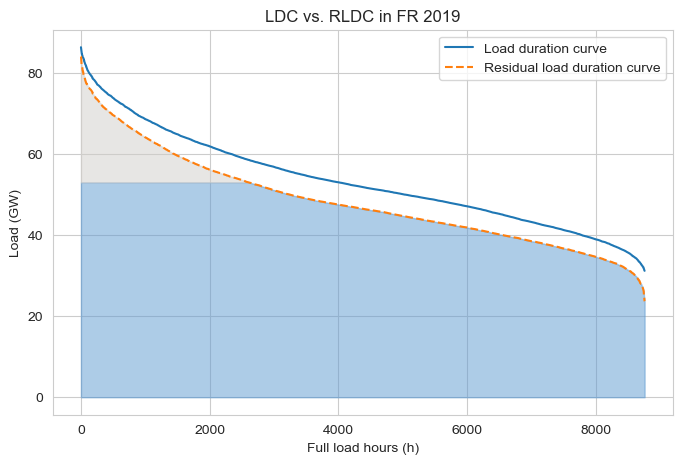

In [26]:
plt.figure(figsize=(8, 5))

# Plotting the curves
plt.plot(plot_df["hour_index"], plot_df["load_actual"], label="Load duration curve",)
plt.plot(plot_df["hour_index"], plot_df["residual_load"], label="Residual load duration curve", linestyle="dashed",)

# Fill areas based on threshold at y=40000
plt.fill_between(plot_df["hour_index"], 0, plot_df["nuclear_cap"], color='#5d9ad1', alpha=0.5)
plt.fill_between(plot_df["hour_index"], 53, plot_df["residual_load"], where=(plot_df["residual_load"] > 53), color='#d1ceca', alpha=0.5)

# Adding labels, title, and legend
plt.xlabel("Full load hours (h)")
plt.ylabel("Load (GW)")
plt.title("LDC vs. RLDC in FR 2019")
plt.legend()

plt.show()

In [27]:
data["residual_load"].sum()

423250.818

## e

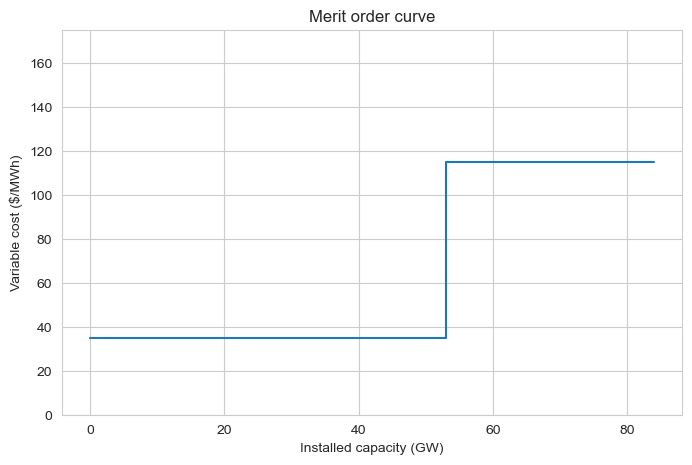

In [28]:
plt.figure(figsize=(8, 5))
plt.step([0, 53, 84], [35 ,115, 115], where="post")
plt.ylim([0, 175])
plt.title("Merit order curve")
plt.xlabel("Installed capacity (GW)")
plt.ylabel("Variable cost ($/MWh)")
plt.show()

## d

In [29]:
scm_dict

{'nuclear': {'afc': 262, 'vc': 35},
 'coal': {'afc': 117, 'vc': 135},
 'gas': {'afc': 58, 'vc': 115}}

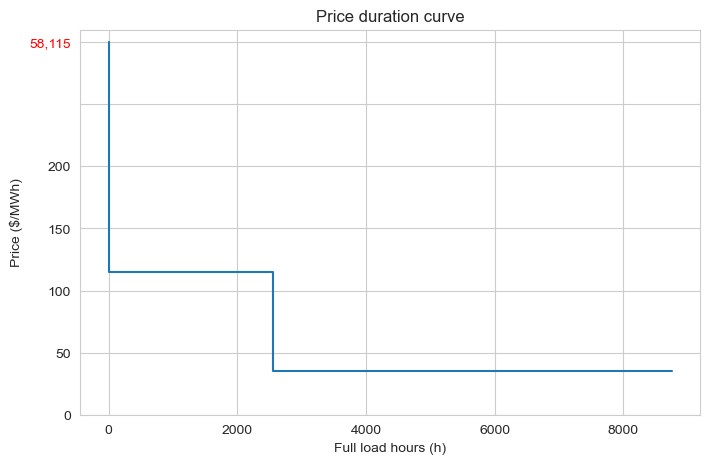

In [30]:
plt.figure(figsize=(8, 5))
plt.step([0, 1, 2550, 8760], [300, 300 ,115, 35], where="pre")
plt.ylim([0, 310])
plt.title("Price duration curve")
plt.xlabel("Full load hours (h)")
plt.ylabel("Price ($/MWh)")
plt.yticks(ticks=[0, 50, 100, 150, 200, 250, 300],
           labels=["0", "50", "100", "150", "200", "", "58,115"])
plt.gca().get_yticklabels()[-1].set_color("red") 
plt.show()